В этом ноутбуке разрабатывается система поиска похожих изображений растений на основе входного изображения.

## Содержание
1. Настройка окружения
2. Загрузка и подготовка данных
3. Модель для извлечения признаков
4. Создание векторов признаков для библиотеки изображений
5. Реализация функции поиска похожих изображений
6. Оценка модели
7. Визуализация результатов (для 5 случайных изображений)
8. Сохранение модели для использования в API

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [8]:
#Фиксирую seed для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [9]:
#Проверка доступности GPU, в обратном случае использую CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Работа с данными

In [10]:
data_dir = "../data/flowers"

#Список классов цветов
flower_classes = os.listdir(data_dir)
print(f"Найдено {len(flower_classes)} классов цветов: {flower_classes}")

Найдено 5 классов цветов: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [12]:
#Кол-во изображений для каждого класса
class_counts = {}
for flower_class in flower_classes:
    class_path = os.path.join(data_dir, flower_class)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        class_counts[flower_class] = len(images)
class_counts

{'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}

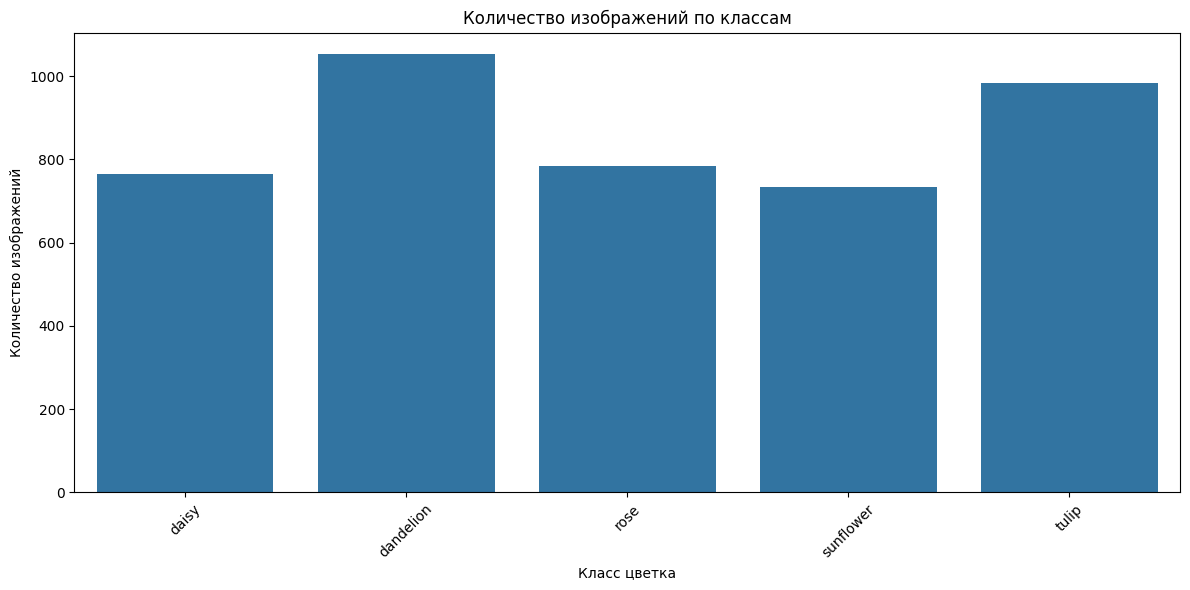

In [14]:
#Визуализация распределения изображений по классам
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Количество изображений по классам')
plt.xlabel('Класс цветка')
plt.ylabel('Количество изображений')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
#Списки путей к изображениям и списки к меткам изображений
image_paths = []
labels = []

In [16]:
for idx, flower_class in enumerate(flower_classes):
    class_path = os.path.join(data_dir, flower_class)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        for image in images:
            image_paths.append(os.path.join(class_path, image))
            labels.append(idx)

In [17]:
#Проверка, чтобы они были одинаковые
print(f"Количество путей: {len(image_paths)}")
print(f"Количество меток: {len(labels)}")

Количество путей: 4317
Количество меток: 4317


In [18]:
#Разделение на train, test, validate
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=SEED, stratify=labels
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

In [19]:
print(f"Тренировочная выборка: {len(train_paths)} изображений")
print(f"Валидационная выборка: {len(val_paths)} изображений")
print(f"Тестовая выборка: {len(test_paths)} изображений")

Тренировочная выборка: 3021 изображений
Валидационная выборка: 648 изображений
Тестовая выборка: 648 изображений


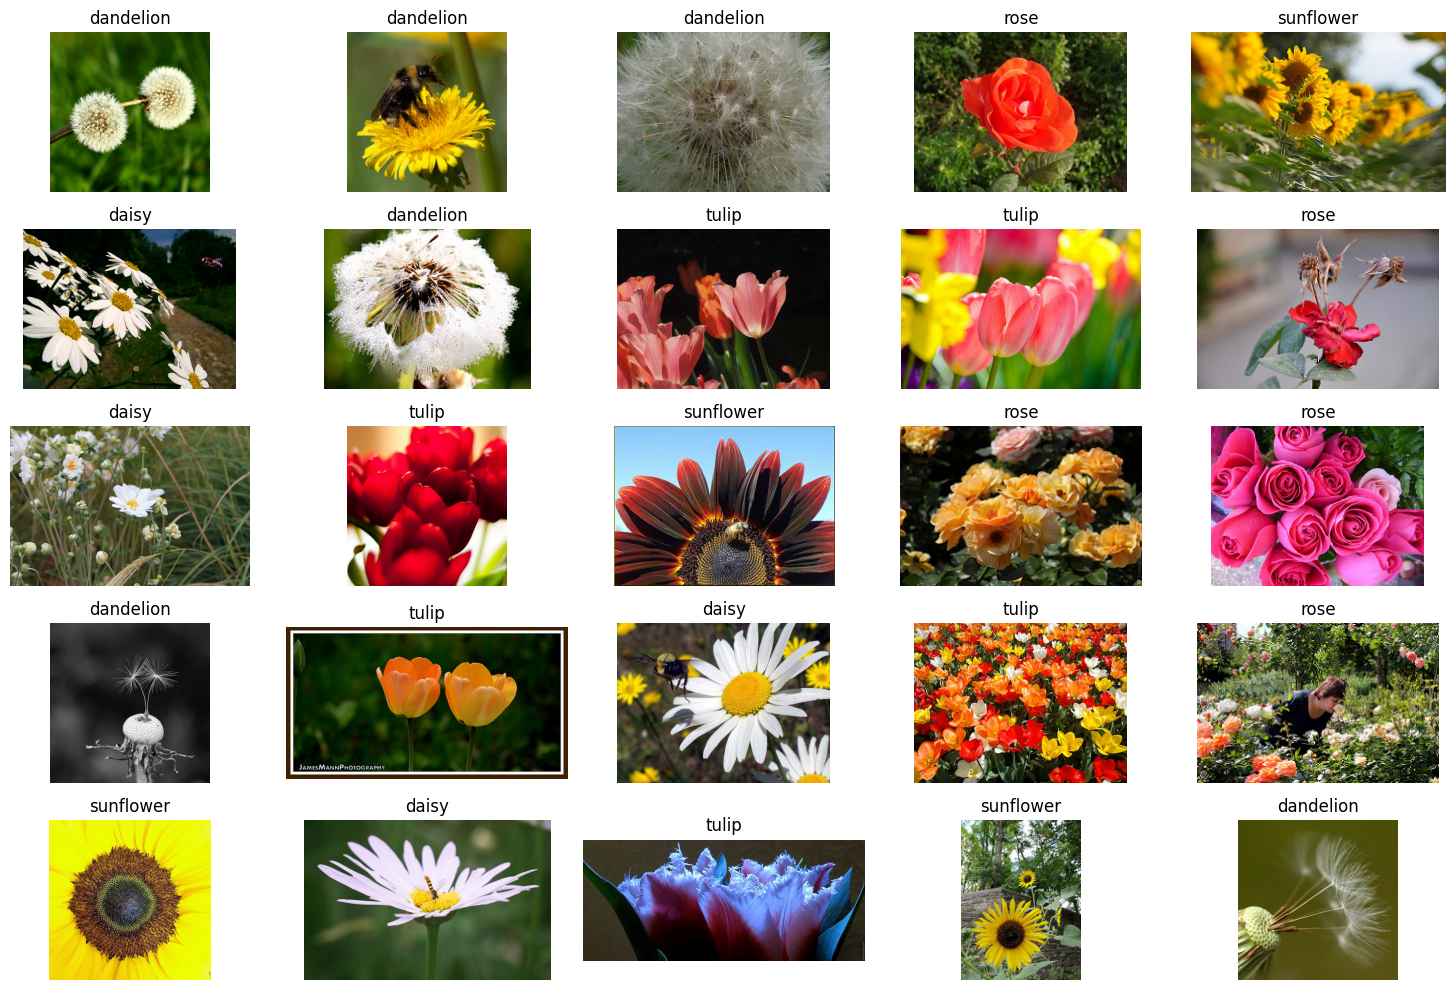

In [20]:
#Визуализация нескольких примеров изображений
plt.figure(figsize=(15, 10))
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        if idx < len(train_paths):
            plt.subplot(5, 5, idx + 1)
            img = Image.open(train_paths[idx])
            plt.imshow(img)
            plt.title(flower_classes[train_labels[idx]])
            plt.axis('off')
plt.tight_layout()
plt.show()

### Датасеты и Даталоадеры

In [21]:
class FlowerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, image_path

In [22]:
#Определение трансформаций для изображений
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
#Создание датасетов
train_dataset = FlowerDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FlowerDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = FlowerDataset(test_paths, test_labels, transform=val_test_transform)

In [25]:
#Создание даталоадеров
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

## Работа с моделью

Для работы используется модель EfficientNet-B0 для извлечения признаков с изображений. 
Сначала использовалась ResNet-50, но она показывала неверные результаты при сравнении изображений, точность была крайне низкой.
Плюсы EfficientNet-B0:
- Использует технику compound scaling, которая оптимально масштабирует глубину, ширину и разрешение модели,
- Улавливает тонкие детали и особенности,
- Работает быстрее ResNet-50,
- Модель уже предуобучена и не требует обучения с нуля,

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
class FeatureExtractor:
    def __init__(self, model_name='resnet50'):
        """
        Инициализация экстрактора признаков
        """
        if model_name == 'resnet50':
            weights = ResNet50_Weights.IMAGENET1K_V1  # или ResNet50_Weights.DEFAULT для самых новых весов
            self.model = resnet50(weights=weights)
            #Удалим последний полносвязанный слой, тк не нужна классификация по исходным классам
            self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))
            self.feature_dim = 2048
            print("[INFO] Выбрана модель: ResNet-50")
        #Вариативность, если resnet не работает корректно
        elif model_name == 'efficientnet_b0':
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1
            self.model = efficientnet_b0(weights=weights)
            #Удалим последний полносвязанный слой, не нужна классификация по исходным классам
            self.model.classifier = torch.nn.Identity()
            self.feature_dim = 1280
            print("[INFO] Выбрана модель: EfficientNet-B0")
        else:
            raise ValueError(f"Unsupported model: {model_name}")
        
        self.model = self.model.to(device)
        self.model.eval()
        
    def extract_features(self, image_tensor):
        """
        Извлечение признаков из тензора изображения
        image_tensor: Тензор изображения размера (batch_size, 3, height, width)   
        Возвращает:
        numpy.ndarray: Извлеченные признаки размера (batch_size, feature_dim)
        """
        with torch.no_grad():
            features = self.model(image_tensor.to(device))
            #Преобразуем в вектор признаков
            features = features.squeeze().cpu().numpy()
            #Если batch_size=1, то добавим размерность
            if len(features.shape) == 1:
                features = features.reshape(1, -1)
            return features
    
    def extract_features_from_image(self, image, transform=None):
        """
        Извлечение признаков из изображения PIL
        image: PIL.Image
        transform: Трансформации для изображения 
        Возвращает:
        numpy.ndarray: Извлеченные признаки
        """
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        image_tensor = transform(image).unsqueeze(0)  # Добавляем размерность batch
        return self.extract_features(image_tensor)

In [39]:
#Создаем экстрактор признаков
feature_extractor = FeatureExtractor(model_name='efficientnet_b0')
print(f"Размерность вектора признаков: {feature_extractor.feature_dim}")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to C:\Users\shevc/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 11.2MB/s]


[INFO] Выбрана модель: EfficientNet-B0
Размерность вектора признаков: 1280


## Создание векторов признаков для библиотеки изображений

In [40]:
import pickle
def extract_features_from_loader(loader, feature_extractor):
    """
    Извлечение признаков для всех изображений в даталоадере
    loader: DataLoader
    feature_extractor: Экстрактор признаков 
    Возвращает:
    Tuple[List[str], numpy.ndarray, List[int]]: Пути к изображениям, признаки, метки
    """
    all_features = []
    all_paths = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, paths in tqdm(loader, desc="Extracting features"):
            features = feature_extractor.extract_features(images)
            all_features.append(features)
            all_paths.extend(paths)
            all_labels.extend(labels.numpy())
            if len(all_features) == 0:
                raise RuntimeError("Признаки не были извлечены — проверь, правильно ли загружается Dataset.")
    
    return all_paths, np.vstack(all_features), all_labels
    

#Извлекаем признаки для тестовой выборки
test_paths, test_features, test_labels = extract_features_from_loader(test_loader, feature_extractor)

#Сохраняем извлеченные признаки и пути для использования в API
library_data = {
    'paths': test_paths,
    'features': test_features,
    'labels': test_labels,
    'classes': flower_classes
}

os.makedirs('../models', exist_ok=True)
with open('../models/library_features.pkl', 'wb') as f:
    pickle.dump(library_data, f)

print(f"Извлечены признаки для {len(test_paths)} изображений библиотеки")
print(f"Размер матрицы признаков: {test_features.shape}")

Extracting features:   0%|          | 0/21 [00:00<?, ?it/s]

Извлечены признаки для 648 изображений библиотеки
Размер матрицы признаков: (648, 1280)


## Функция поиска похожих изображений

In [47]:
def find_similar_images(query_feature, library_features, library_paths, top_n=5, exclude_index=None):
    """
    Поиск наиболее похожих изображений на основе косинусного сходства
    query_feature: Вектор признаков запроса
    library_features: Матрица признаков библиотеки
    library_paths: Пути к изображениям в библиотеке
    top_n: Количество наиболее похожих изображений
    Возвращает:
    Dict[str, float]: Словарь с путями к изображениям и показателями сходства
    """
    #Косинусное сходство между запросом и всеми изображениями. Косинусное автоматически нормализует вектора и т.к. нам важна направленность.
    similarities = cosine_similarity(query_feature.reshape(1, -1), library_features)[0]
    
    if exclude_index is not None:
        similarities[exclude_index] = -1  # Присваиваем очень низкое значение, чтобы исключить

    #Находим индексы top_n наиболее похожих изображений
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    #Создаем словарь результатов
    result = {}
    for idx in top_indices:
        result[library_paths[idx]] = float(similarities[idx])
    
    return result

In [48]:
#Выберем случайное изображение из тестовой выборки для запроса
query_idx = random.randint(0, len(test_paths) - 1)
query_path = test_paths[query_idx]
query_feature = test_features[query_idx]

Выбрано изображение для запроса: ../data/flowers\rose\5223191368_01aedb6547_n.jpg


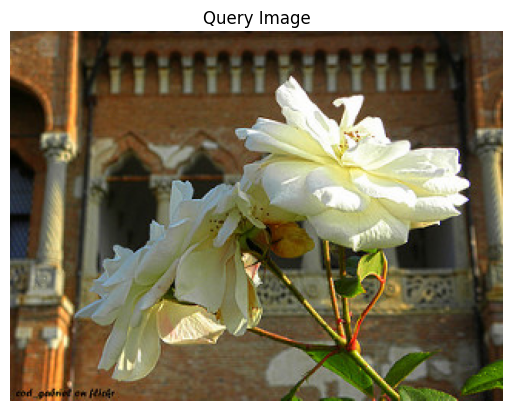

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

print(f"Выбрано изображение для запроса: {query_path}")

query_image = Image.open(query_path)

plt.imshow(query_image)
plt.axis('off')
plt.title("Query Image")
plt.show()

In [50]:
#Найдем похожие изображения
similar_images = find_similar_images(query_feature, test_features, test_paths, exclude_index=query_idx)
print("Пример результата поиска:")
for path, score in similar_images.items():
    print(f"{path}: {score:.4f}")

Пример результата поиска:
../data/flowers\rose\5231103167_a03280e9f6_n.jpg: 0.5322
../data/flowers\sunflower\6265084065_7a8b30cc6e_n.jpg: 0.5031
../data/flowers\rose\5249566718_6109630c83_m.jpg: 0.4556
../data/flowers\rose\5001847693_77a9fb4f3c_n.jpg: 0.4556
../data/flowers\tulip\17291930305_79deae6a90_n.jpg: 0.4480


Запросное изображение: ../data/flowers\rose\5223191368_01aedb6547_n.jpg


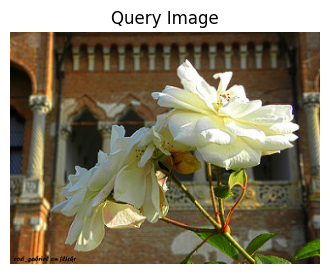

Похожие изображения:


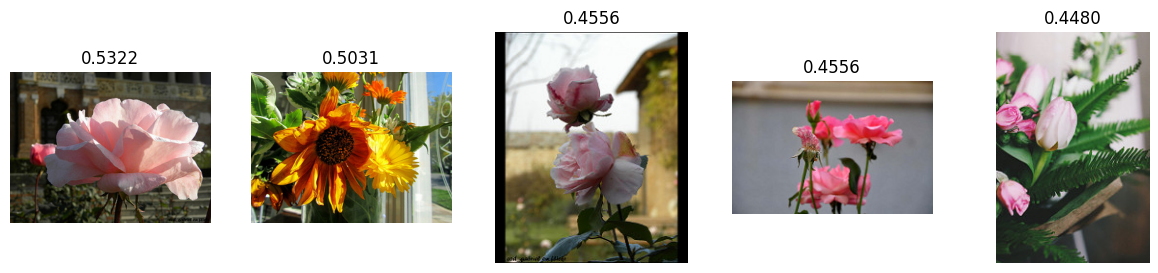

In [51]:
import matplotlib.pyplot as plt
from PIL import Image

# Показать запросное изображение
print(f"Запросное изображение: {query_path}")
query_image = Image.open(query_path)
plt.figure(figsize=(4,4))
plt.imshow(query_image)
plt.axis('off')
plt.title("Query Image")
plt.show()

# Показать похожие изображения с оценками
print("Похожие изображения:")
plt.figure(figsize=(15, 3))

for i, (path, score) in enumerate(similar_images.items()):
    img = Image.open(path)
    plt.subplot(1, len(similar_images), i+1)
    plt.imshow(img)
    plt.title(f"{score:.4f}")
    plt.axis('off')

plt.show()
